In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import math
import numpy as np
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics import silhouette_samples, silhouette_score

## Load Dataset

In [2]:
#load iris dataset
data_iris = load_iris()
iris_data, iris_y = load_iris(return_X_y=True)
feature_iris = data_iris['feature_names']

In [3]:
#transform iris into dataframe
iris_X=pd.DataFrame(iris_data)

In [4]:
iris_X[0:50]

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [5]:
iris_X.rename(columns = {0:feature_iris[0],1:feature_iris[1],2:feature_iris[2],3:feature_iris[3]}, inplace = True)

## K-Means Algorithm

In [6]:
# return minimum value and maximum value from array
def rangeFeature(data):
    return data.min(),data.max()

In [7]:
# return array that contain all range from every feature
def setRange(data):
    dataMin = []
    dataMax = []
    for index,col in enumerate(data.columns):
        tmpMin,tmpMax=rangeFeature(data[col])
        dataMin.append(tmpMin)
        dataMax.append(tmpMax)
    return dataMin,dataMax

In [8]:
# initialize every centroid based on range every feature
def initCentroid(cluster,dimension,dataMin,dataMax):
    centroid = []
    for i in range(cluster):
        point = []
        for j in range(dimension):
            pos = np.random.uniform(dataMin[j],dataMax[j])
            point.append(pos)
        centroid.append(point)
    return centroid

In [9]:
# calculate distance from 2 point using euclidian distance
def distFromCentroid(point1,point2):
    sumSquare = 0
    dimension = len(point1)
    for i in range(dimension):
        sumSquare += (point1[i]-point2[i])**2
    return sumSquare ** 0.5

In [10]:
# save every distance from every instance
def checkDistCentroid(centroid,data,cluster):
    distAllCentroid = []
    lenData = len(data)
    
    for i in range(cluster):
        distCentroid = []
        for j in range(lenData):
            dist = distFromCentroid(data.loc[j].values,centroid[i])
            distCentroid.append(dist)
        distAllCentroid.append(distCentroid)
    return distAllCentroid

In [11]:
# assign cluster from one instance with closest cluster
def checkCluster(dist,cluster):
    mn = dist[0]
    idx = 0
    for i in range(1,cluster):
        if (mn>dist[i]):
            mn = dist[i]
            idx = i
    return idx

In [12]:
# Save every cluster in all instance to array
def clustering(distance,cluster,lenData):
    clusterNow = []
    for i in range(lenData):
        clusterNow.append(checkCluster(distance[i],cluster))
    return clusterNow

In [13]:
# moving centroid based on average point from new cluster
def moveCentroid(cluster,data):
    lenData = len(data)
    cntCluster = max(cluster) + 1
    centroid = []
    
    for i in range(cntCluster):
        cnt = 0
        point = [0]*len(data.columns)
        # get sum of coordinate one cluster
        for j in range(lenData):
            if (cluster[j]==i):
                cnt+=1
                for k,col in enumerate(data.columns):
                    point[k] += data.loc[j][col]
        # get average of coordinate one cluster
        for j in range(len(data.columns)):
            if (cnt != 0):
                point[j] /= cnt 
        centroid.append(point)
    return centroid

In [14]:
# K-Means Clustering with parameter dataset that used and number of cluster that will formed
# return cluster from dataset
def kmeans(data,cluster):
    dataMin = []
    dataMax = []
    centroid = []
    distance = []
    lenData = len(data)
    clusterNow = []
    prevCluster = []
    
    # set range every columns
    dataMin,dataMax = setRange(data)
    # inisialize centroid
    centroid = initCentroid(cluster,len(data.columns),dataMin,dataMax)
    # check distance from centroid
    distance = pd.DataFrame(checkDistCentroid(centroid,data,cluster))
    # clustering
    clusterNow = clustering(distance, cluster, lenData)
    
    while(clusterNow != prevCluster):
        prevCluster = clusterNow
        centroid = moveCentroid(clusterNow,data)
        distance = pd.DataFrame(checkDistCentroid(centroid,data,cluster))
        clusterNow = clustering(distance, cluster, lenData)
    return clusterNow

In [15]:
ans = kmeans(iris_X,3)

## Evaluasi

### Fowlkes_Mallows

In [16]:
fowlkes_mallows_score(ans, iris_y)

0.8112427991975698

### Silhouette Coefficient

In [17]:
silhouette_score(iris_data, ans)

0.5511916046195915

## Visualization K-Means Algorithm
Kami menggambar dalam 2 dimensi untuk setiap pasangan kolom (column1 dan column2) yang mungkin dari dataset yang diberikan. Kemudian hasil clustering direpresentasikan sebagai warna yang berbeda.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualization_k_means(train_data, number_of_cluster):
    clustering_result = kmeans(train_data, number_of_cluster)
    clustering_res = pd.DataFrame(clustering_result)
    data = pd.concat([iris_X, clustering_res], axis=1)
    data.rename(columns={0:"clustering_result"}, inplace = True)
    column_name = train_data.columns
    for column1 in column_name:
        for column2 in column_name:
            if(column1 != column2):
                sns.lmplot(column1, column2, data=data, hue='clustering_result', fit_reg=False)
                ax = plt.gca()
                ax.set_title('Clustering Result')
                plt.show()

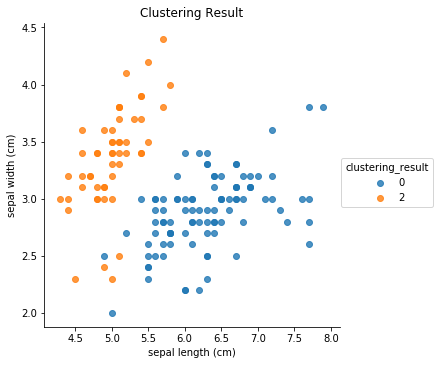

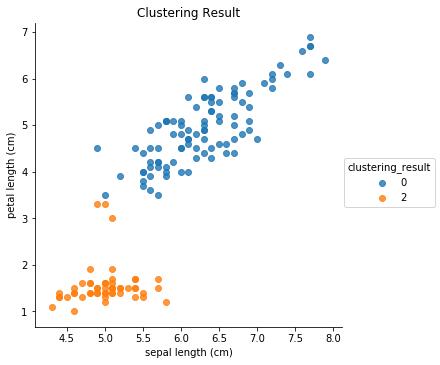

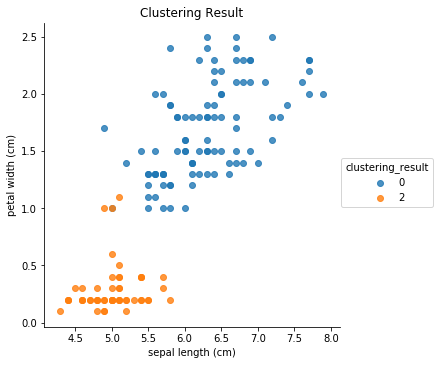

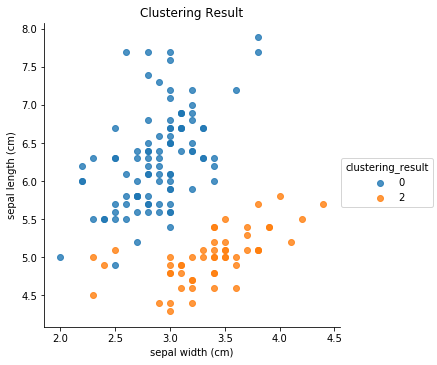

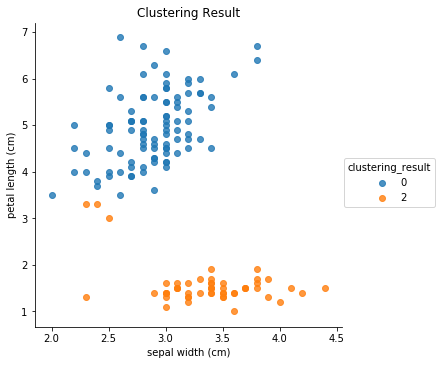

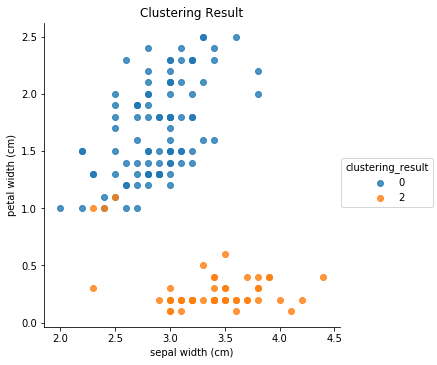

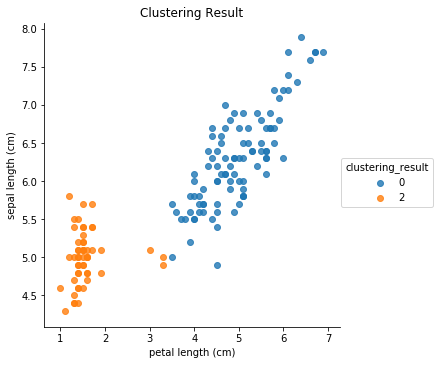

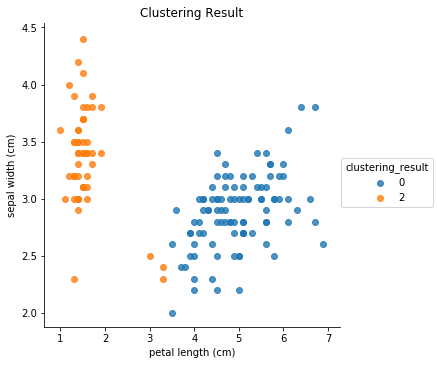

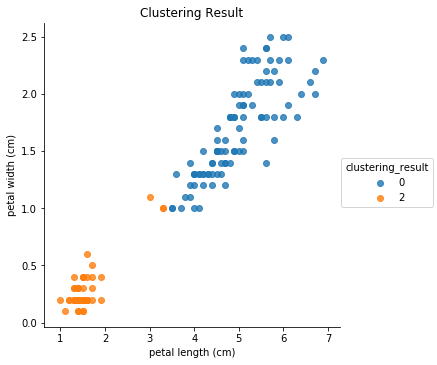

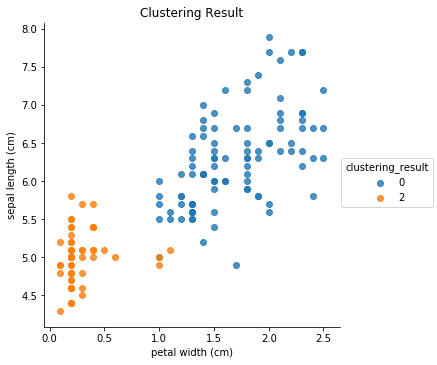

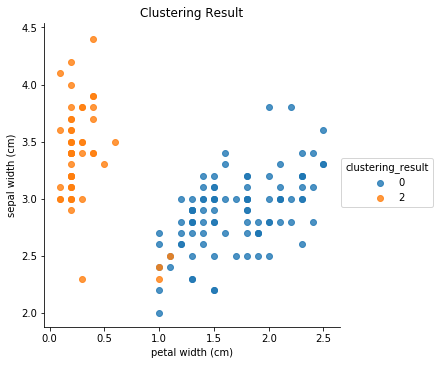

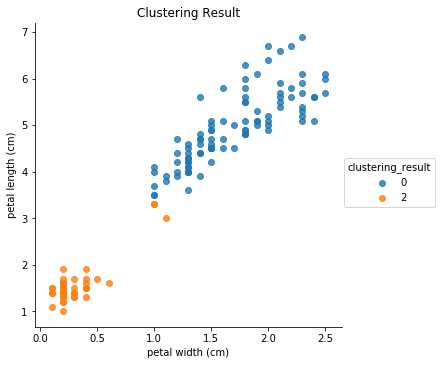

In [19]:
visualization_k_means(iris_X, 3)

## Agglomerative Algorithm

In [20]:
def euclidean_dist(point1, point2):
    distance = 0
    dimension = len(point1)
    
    for i in range(dimension):
        distance += (point1[i]-point2[i])**2
        
    return distance ** 0.5

In [21]:
def init_proximity_matrix(data):
    matrix = [[0 for i in range(len(data))] for j in range(len(data))]
    
    for i in range(len(data)):
        for j in range(i, len(data)):
            if (i != j):
                proximity = euclidean_dist(data.loc[i].values, data.loc[j].values)
                matrix[i][j] = proximity
                matrix[j][i] = proximity
    
    return matrix

In [22]:
def init_cluster(n_cluster):
    clusters = []
    
    for i in range(n_cluster):
        clusters.append(str(i))
        
    return clusters

In [23]:
def find_shortest_dist(proximity_matrix):
    min_distance = float("inf")
    result = [0, 1]
    
    for i in range(len(proximity_matrix)):
        for j in range(i, len(proximity_matrix)):
            if (proximity_matrix[i][j] > 0) and (proximity_matrix[i][j] < min_distance):
                min_distance = proximity_matrix[i][j]
#                 print(min_distance)
                result[0] = i
                result[1] = j
    
    return result

In [24]:
def update_clusters(clusters, cluster1, cluster2):
    updated_clusters = []
    
    for i in range(len(clusters)-1):
        if (i != cluster1):
            if (i >= cluster2):
                updated_clusters.append(clusters[i+1])
            else:
                updated_clusters.append(clusters[i])
        else:
            updated_clusters.append(clusters[cluster1] + "," + clusters[cluster2])
    
    return updated_clusters

In [25]:
def update_proximity_matrix(matrix, cluster1, cluster2, linkage, clusters, data):
    updated_matrix = [[0 for i in range(len(matrix)-1)] for j in range(len(matrix)-1)]

    for i in range(len(updated_matrix)):
        if (i != cluster1):
            idx_i = i
            if (i >= cluster2):
                idx_i += 1

            for j in range(idx_i, len(updated_matrix)):
                if (i != j):
                    if (j != cluster1):
                        if (j >= cluster2):
                            updated_matrix[i][j] = matrix[idx_i][j+1]
                            updated_matrix[j][i] = matrix[idx_i][j+1]
                        else:
                            updated_matrix[i][j] = matrix[idx_i][j]
                            updated_matrix[j][i] = matrix[idx_i][j]
                    else:
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                            updated_matrix[j][i] = min([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                            updated_matrix[j][i] = max([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                        elif (linkage == "average"):
                            updated_matrix[i][j] = (matrix[idx_i][cluster1] + matrix[idx_i][cluster2])/2
                            updated_matrix[j][i] = (matrix[idx_i][cluster1] + matrix[idx_i][cluster2])/2
                        elif (linkage == "average-group"):
                            mean_distance = cluster_means_distance(clusters[i], clusters[cluster1], clusters, data)
                            updated_matrix[i][j] = mean_distance
                            updated_matrix[j][i] = mean_distance
        else:
            for j in range(i, len(updated_matrix)):
                if (i != j):
                    if (j >= cluster2):
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                            updated_matrix[j][i] = min([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                            updated_matrix[j][i] = max([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                        elif (linkage == "average"):
                            updated_matrix[i][j] = (matrix[cluster1][j+1] + matrix[cluster2][j+1])/2
                            updated_matrix[j][i] = (matrix[cluster1][j+1] + matrix[cluster2][j+1])/2
                        elif (linkage == "average-group"):
                            mean_distance = cluster_means_distance(clusters[i], clusters[j], clusters, data)
                            updated_matrix[i][j] = mean_distance
                            updated_matrix[j][i] = mean_distance
                    else:
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[cluster1][j], matrix[cluster2][j]]) 
                            updated_matrix[j][i] = min([matrix[cluster1][j], matrix[cluster2][j]]) 
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[cluster1][j], matrix[cluster2][j]]) 
                            updated_matrix[j][i] = max([matrix[cluster1][j], matrix[cluster2][j]]) 
                        elif (linkage == "average"):
                            updated_matrix[i][j] = (matrix[cluster1][j] + matrix[cluster2][j])/2
                            updated_matrix[j][i] = (matrix[cluster1][j] + matrix[cluster2][j])/2
                        elif (linkage == "average-group"):
                            mean_distance = cluster_means_distance(clusters[cluster1], clusters[j], clusters, data)
                            updated_matrix[i][j] = mean_distance
                            updated_matrix[j][i] = mean_distance
                        
    return updated_matrix

In [26]:
def cluster_means_distance(a, b, clusters, data) :
    
    cluster_1 = a.split(',')
    cluster_2 = b.split(',')
    
    means_1 = [0]*len(data.columns)
    for i in range(len(cluster_1)):
        for k,col in enumerate(data.columns):
            means_1[k] += data.loc[i][col]
    
    for i in range(len(data.columns)):
        means_1[i] /= len(cluster_1) 
    
    means_2 = [0]*len(data.columns)
    for i in range(len(cluster_2)):
        for k,col in enumerate(data.columns):
            means_2[k] += data.loc[i][col]
    
    for i in range(len(data.columns)):
        means_2[i] /= len(cluster_2)
    
    distance = 0
    for i in range(len(data.columns)):
        distance += (means_1[i]-means_2[i]) ** 2
        
        
    return (distance) ** 0.5
    

In [27]:
def MakeMatrix(size):
    return [["" for i in range (size)] for j in range(size)]

In [28]:
def agglomerative(data, cluster, linkage):
    n_cluster = len(data)
    proximity_matrix = init_proximity_matrix(data)
    clusters = init_cluster(n_cluster)
    
    if (len(data) > 1):
        idx_row = 0;
        mat_size = len(data)
        mat = MakeMatrix(mat_size)
        for i in range(mat_size):
            mat[idx_row][i] = clusters[i]

        while (n_cluster > cluster):             
            cluster_pair = find_shortest_dist(proximity_matrix)
            
            for i in range(mat_size):
                mat[idx_row+1][i] =  mat[idx_row][i]
            
            pos_1 = -999
            pos_2 = -999
            for i in range(mat_size):
                if(mat[idx_row+1][i] == clusters[cluster_pair[0]]):
                    pos_1 = i
                    break
            
            for i in range(mat_size):
                if(mat[idx_row+1][i] == clusters[cluster_pair[1]]):
                    pos_2 = i
                    break
            
            
            pos_left = min(pos_1, pos_2)
            pos_right = max(pos_1, pos_2)
            mat[idx_row+1][pos_left] = mat[idx_row+1][pos_left] + "," + mat[idx_row+1][pos_right]
            mat[idx_row+1][pos_right] = ""
            
            clusters = update_clusters(clusters, cluster_pair[0], cluster_pair[1]) 
            
            proximity_matrix = update_proximity_matrix(proximity_matrix, cluster_pair[0], cluster_pair[1], linkage, clusters, data)
            
            n_cluster -= 1
            idx_row +=1
            offset = data
    return clusters, mat, len(data) - cluster

In [29]:
agglo_result_average = agglomerative(iris_X, 3, "average")
print(agglo_result_average[0])

['0,17,40,4,37,7,39,49,27,28,10,48,19,21,46,20,31,36,23,26,43,24,44,5,18,16,32,33,14,15,1,45,12,9,34,25,35,2,3,47,6,11,29,30,8,38,42,13,22,41', '50,52,86,76,77,54,58,65,75,51,56,85,61,71,74,97,63,91,78,73,55,90,66,84,62,68,87,53,89,69,80,81,67,82,92,88,95,96,94,99,59,64,79,57,93,98,60,106,70,127,138,149,101,113,142,121,114,72,83,133,123,126,146,119,134,100,110,147,112,139,141,145,115,136,148,120,143,140,144,124,103,116,137,111,104,128,132,108', '102,125,129,107,130,135,105,122,118,109,117,131']


In [30]:
agglo_result_single = agglomerative(iris_X, 3, "single")
print(agglo_result_single[0])

['0,17,40,4,37,7,39,49,27,28,35,10,48,23,26,43,1,9,34,45,12,29,30,25,2,3,47,8,38,42,11,6,19,21,46,13,24,36,20,31,5,18,16,32,33,44,15,14,22,41', '50,52,86,51,56,54,58,65,75,74,97,77,76,71,53,89,69,80,81,67,82,92,88,94,95,96,99,90,61,55,66,84,63,91,78,73,79,85,59,70,127,138,123,126,146,149,101,113,121,72,83,133,103,116,137,104,128,132,110,147,111,141,145,112,139,120,143,140,144,124,115,136,148,102,125,129,64,100,119,107,130,114,62,68,87,105,122,118,135,134,108,109,57,93,60,98,106,117,131', '142']


In [31]:
agglo_result_complete = agglomerative(iris_X, 3, "complete")
print(agglo_result_complete[0])

['0,17,40,7,39,49,27,28,4,37,35,1,45,12,9,34,25,29,30,2,3,47,42,6,8,38,13,22,41,5,18,10,48,36,20,31,11,24,23,26,43,19,21,46,44,14,15,16,32,33', '50,52,86,77,54,58,76,65,75,51,56,85,63,91,78,73,74,97,68,87,119,70,127,138,149,101,113,142,121,114,72,83,133,123,126,111,146,134,100,136,148,120,143,124,140,144,103,116,137,104,128,132,108,110,147,115,112,139,141,145,102,125,129,107,130,105,122,118,109,135,117,131', '53,89,69,80,81,59,64,79,62,55,90,66,84,61,71,67,82,92,88,95,96,94,99,106,57,93,98,60']


In [32]:
agglo_result_average_group = agglomerative(iris_X, 3, "average-group")
print(agglo_result_average_group[0])

['0,17,5,1,45,2,6,3,47,4,37,7,39,8,38,9,34,11,12,13,14,15,16,18,20,22,24,25,31,32,33,36,40,41,42,43,44,46,55,59,60,61,62,64,67,69,70,71,72,73,76,77,78,10,48,79,19,21,23,26,27,28,29,30,35,49,50,52,51,56,83,85,86,88,90,98,100,102,103,104,106,108,109,111,114,115,117,118,119,121,124,125,129,131,133,134,135,142,146,149,53,89,54,58,57,93,63,91,65,75,66,84,68,87,74,97,80,81,82,92,94,99,95,96,101,113,105,122,107,130,110,147,112,139,116,137,120,143,123,126,127,138,128,132,136,148', '140,144', '141,145']


In [33]:
print(agglo_result_average_group[1])

[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149'], ['0', '1', '2', '3', '4', '5', '6', '7,39', '8', '9', '10

 ### Convert Result To Array

In [34]:
def get_dict_agglo_cluster_result(agglo_result_string):
    agglo_cluster_result = {}
    i = 1
    for data in agglo_result_string:
        temp = data.split(",")
        for instance in temp:
            agglo_cluster_result[int(instance)] = i
        i = i+1
    return agglo_cluster_result

In [35]:
def convResult(result):
    dict_target = get_dict_agglo_cluster_result(result)
    data = [0]*len(dict_target)
    for key, value in dict_target.items():
        data[key] = value
    return data

In [36]:
arr_agglo_result_average = convResult(agglo_result_average[0])
arr_agglo_result_single = convResult(agglo_result_single[0])
arr_agglo_result_complete = convResult(agglo_result_complete[0])
arr_agglo_result_average_group = convResult(agglo_result_average_group[0])

## Evaluation

### Average

### Fowlkes_Mallows

In [38]:
fowlkes_mallows_score(arr_agglo_result_average, iris_y)

0.7421637537684369

### Silhouette Coefficient

In [39]:
silhouette_score(iris_data, arr_agglo_result_average)

0.5340213263943496

### Single

### Fowlkes_Mallows

In [40]:
fowlkes_mallows_score(arr_agglo_result_single, iris_y)

0.7673442541005148

### Silhouette Coefficient

In [41]:
silhouette_score(iris_data, arr_agglo_result_single)

0.13275799366110824

### Complete

### Fowlkes_Mallows

In [42]:
fowlkes_mallows_score(arr_agglo_result_complete, iris_y)

0.7686371028513819

### Silhouette Coefficient

In [43]:
silhouette_score(iris_data, arr_agglo_result_complete)

0.5135953221192208

### Average Group

### Fowlkes_Mallows

In [44]:
fowlkes_mallows_score(arr_agglo_result_average_group, iris_y)

0.5590321940207358

### Silhouette Coefficient

In [45]:
silhouette_score(iris_data, arr_agglo_result_average_group)

-0.12306815802144098

## Visualization Agglomerative Algorithm

## Dendogram
Dendogram tidak ditampilkan karena ukurannya sangat rumit sekali. Bahkan dataset iris yang memiliki 150 instance akan sangat rumit dendogramnya. Oleh karena itu kami menyimpan dendogram dalam file csv

### Complete

In [49]:
temp_2 = agglomerative(iris_X, 3, "complete")[1]

headers = []
for i in range(150):
    headers.append("instance ke-"+str(i))

df = pd.DataFrame(temp_2, columns=headers)

df.to_csv("dendogram_complete_linkage.csv", sep='\t', encoding='utf-8')

### Single

In [52]:
temp = agglomerative(iris_X, 3, "single")[1]

headers = []
for i in range(150):
    headers.append("instance ke-"+str(i))

df = pd.DataFrame(temp, columns=headers)

df.to_csv("dendogram_single_linkage.csv", sep='\t', encoding='utf-8')

### Average

In [51]:
temp_1 = agglomerative(iris_X, 3, "average")[1]

headers = []
for i in range(150):
    headers.append("instance ke-"+str(i))

df = pd.DataFrame(temp_1, columns=headers)

df.to_csv("dendogram_average_linkage.csv", sep='\t', encoding='utf-8')

### Average Group

In [54]:
temp_3 = agglomerative(iris_X, 3, "average_group")[1]

headers = []
for i in range(150):
    headers.append("instance ke-"+str(i))

df = pd.DataFrame(temp_3, columns=headers)

df.to_csv("dendogram_average_group_linkage.csv", sep='\t', encoding='utf-8')

## Scatter Plot

In [55]:
import copy
def display(train_data, dic_target):
    data_result = copy.deepcopy(train_data)
    column_name = train_data.columns
    data_result["clustering_result"] = 0
    for key, value in dic_target.items():
        data_result["clustering_result"][key] = value;
    
    for column1 in column_name:
        for column2 in column_name:
            if(column1 != column2):
                sns.lmplot(column1, column2, data=data_result, hue='clustering_result', fit_reg=False)
                ax = plt.gca()
                ax.set_title('Clustering Result')
                plt.show()

In [56]:
def visualization_agglo_result(train_data, num_cluster, linkage):
    dic_target = get_dict_agglo_cluster_result(agglomerative(iris_X, num_cluster, linkage)[0])
    display(train_data, dic_target)

#### Note : To get desired visualizion aggloromerative result
Please run it in order from line cell that defined function get_dict_agglo_cluster_result(agglo_result_string)

### Complete

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


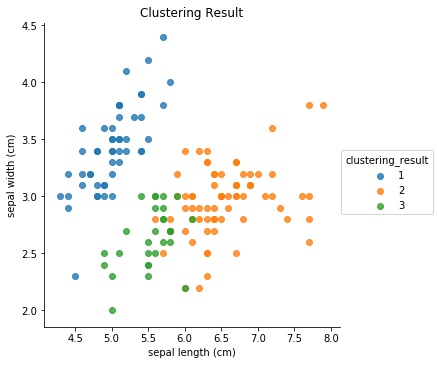

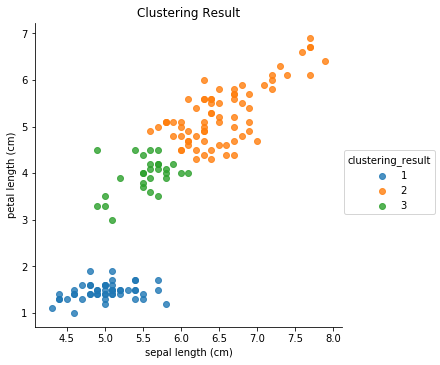

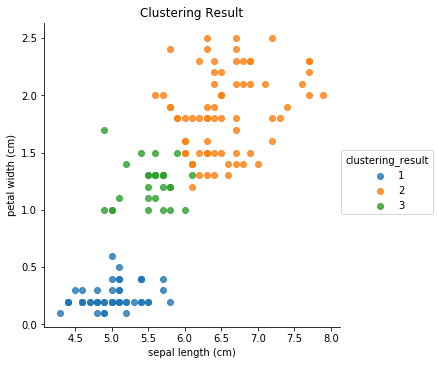

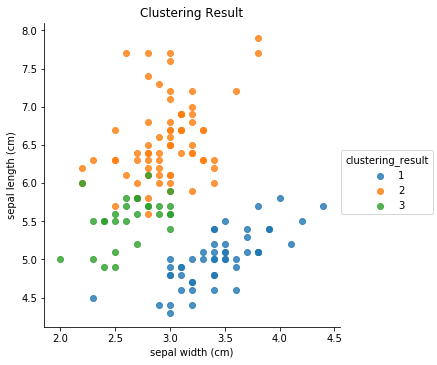

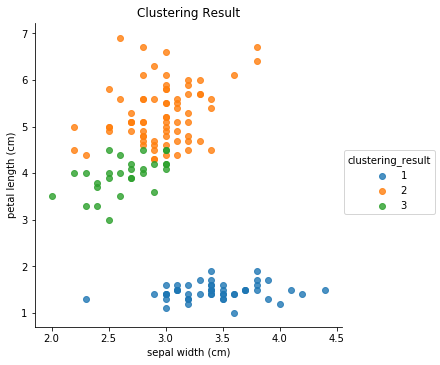

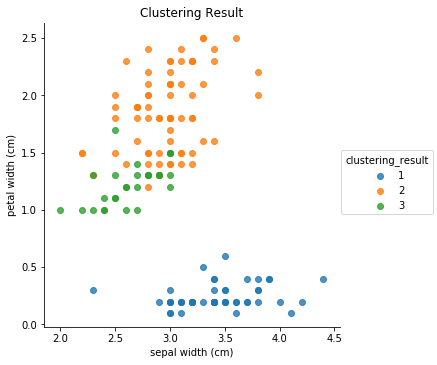

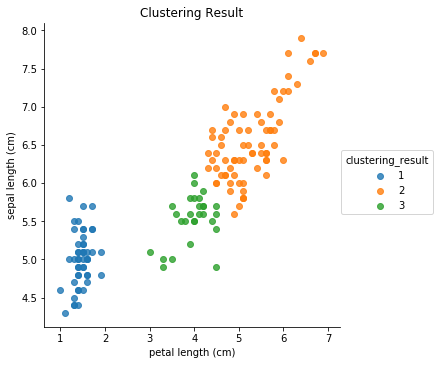

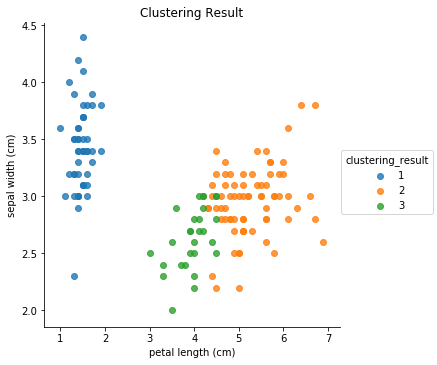

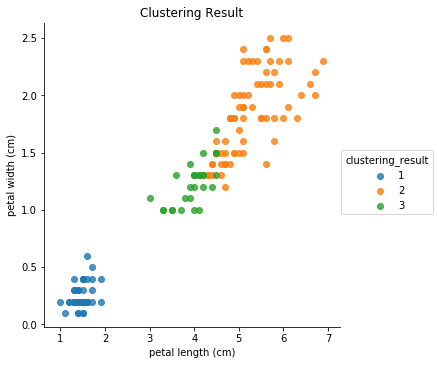

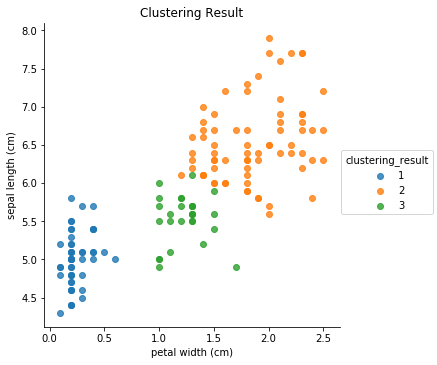

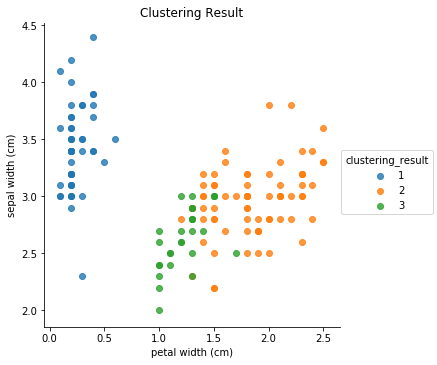

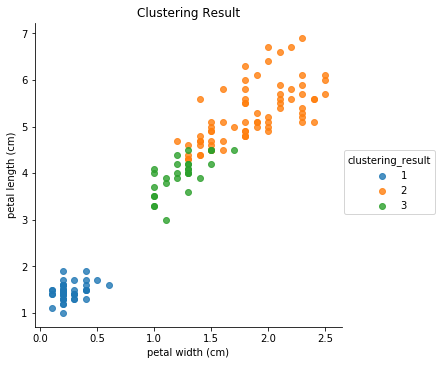

In [57]:
visualization_agglo_result(iris_X, 3, "complete")

### Single

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


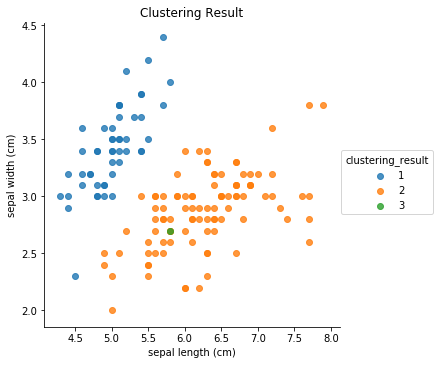

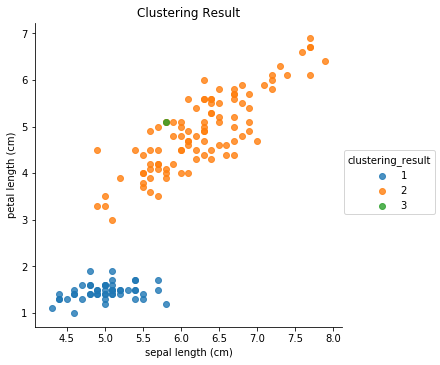

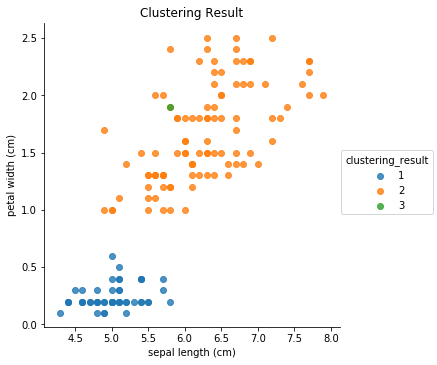

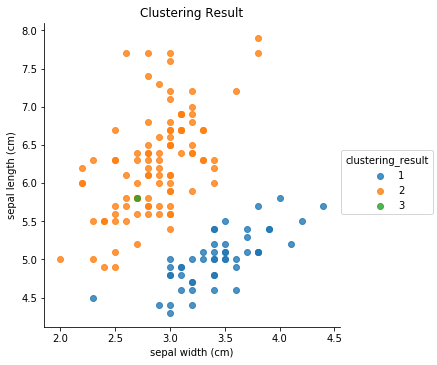

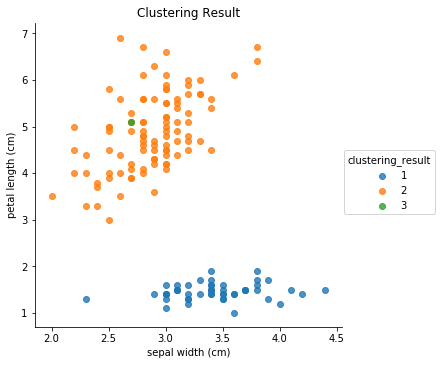

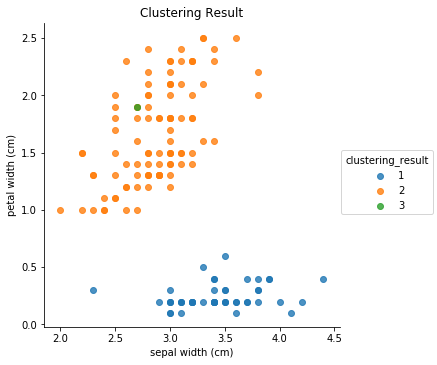

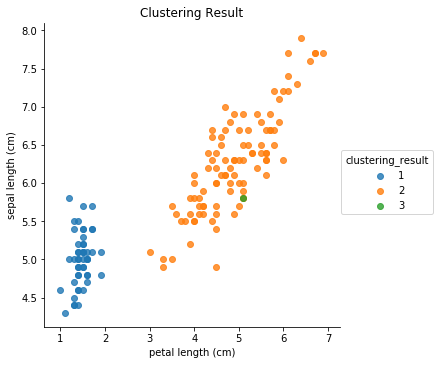

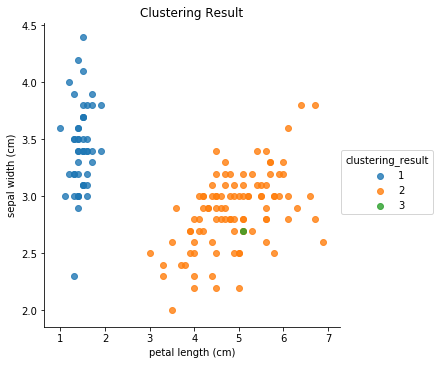

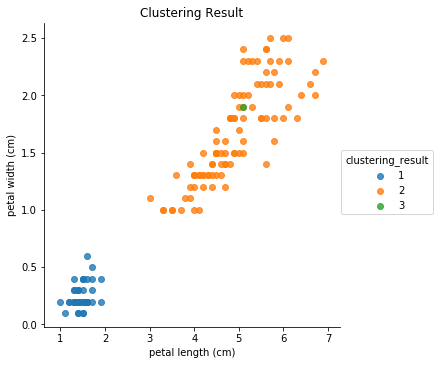

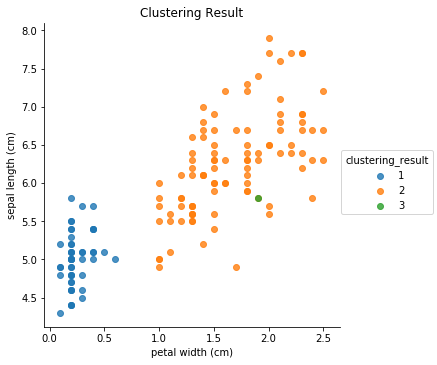

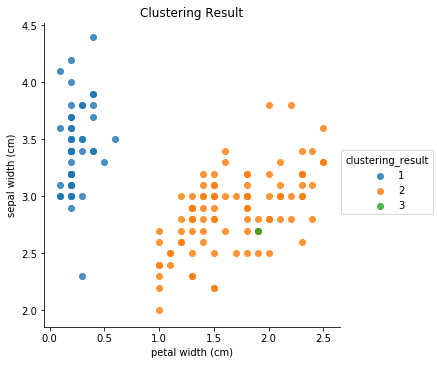

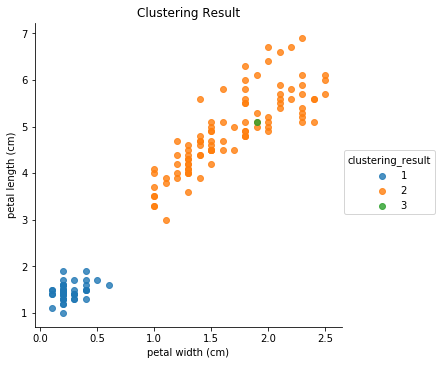

In [58]:
visualization_agglo_result(iris_X, 3, "single")

### Average

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


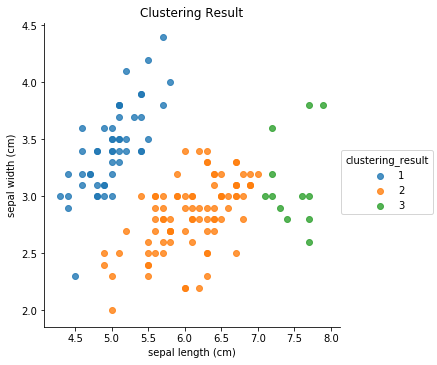

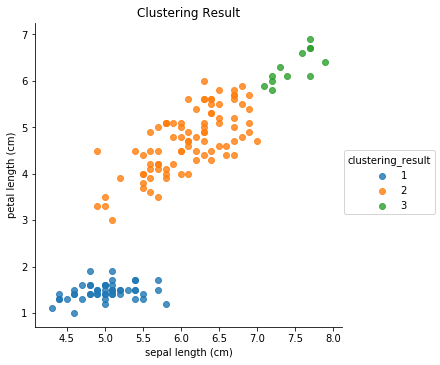

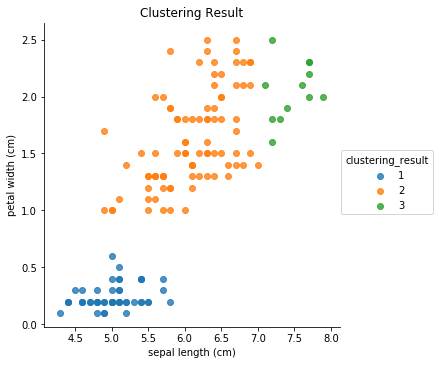

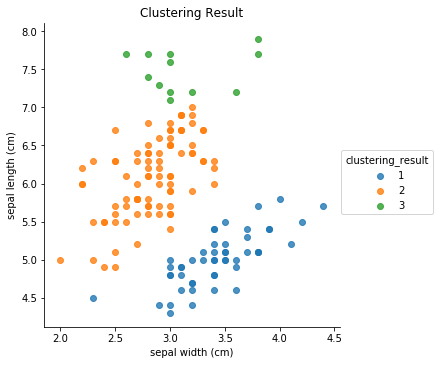

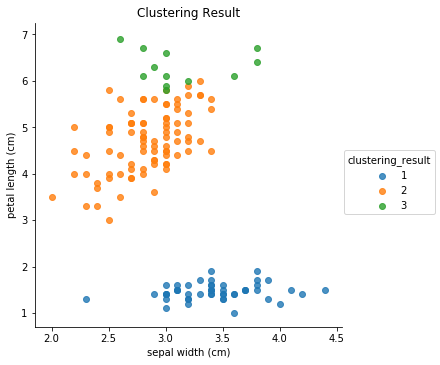

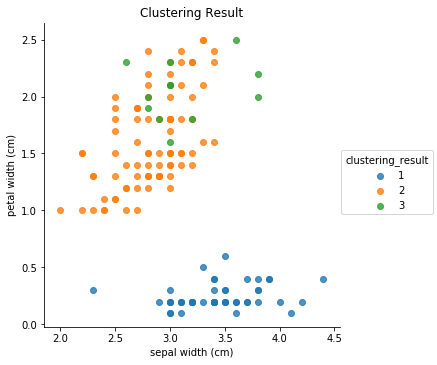

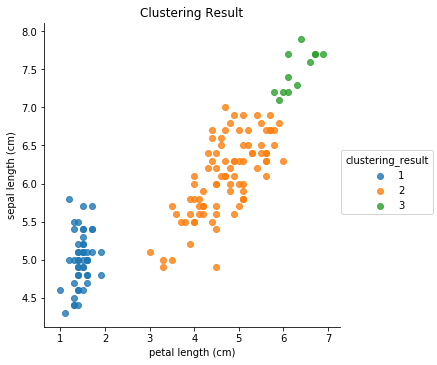

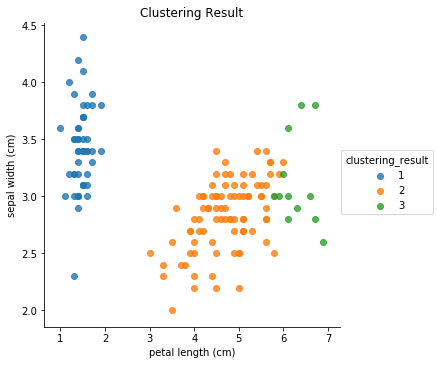

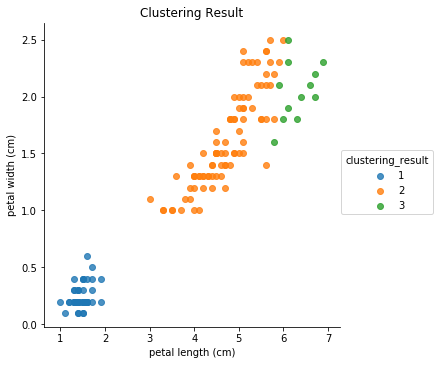

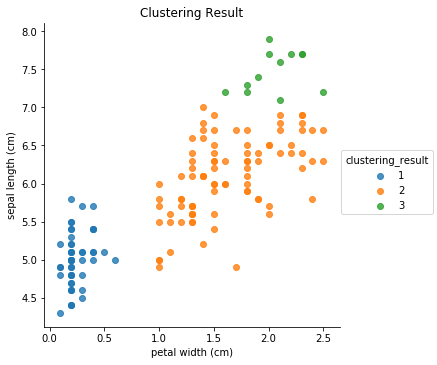

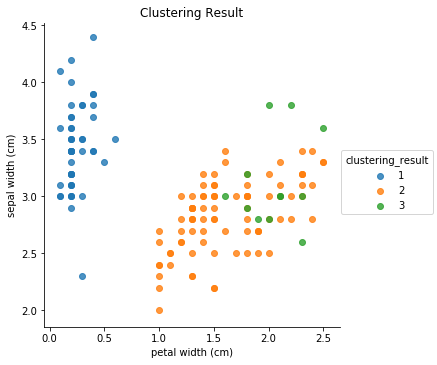

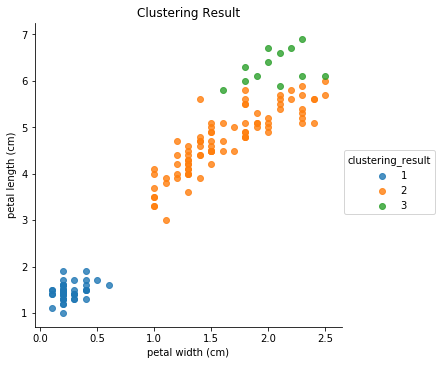

In [59]:
visualization_agglo_result(iris_X, 3, "average")

### Average Group

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


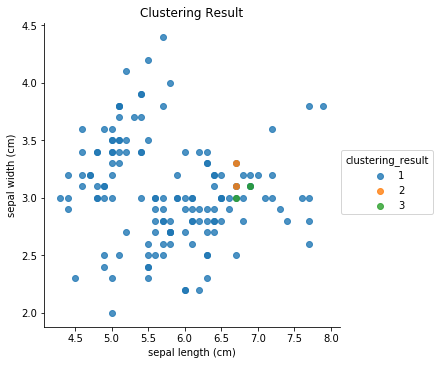

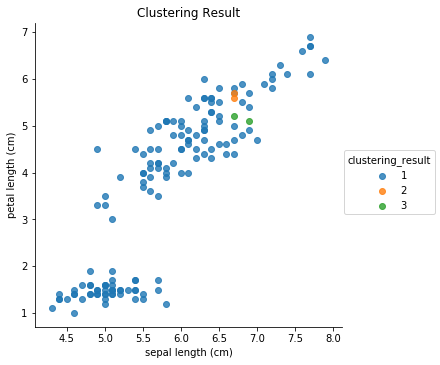

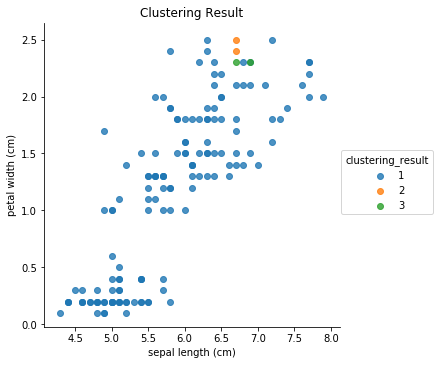

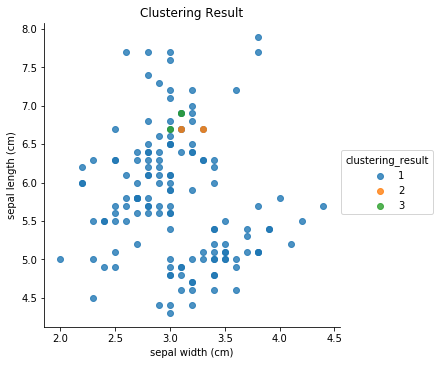

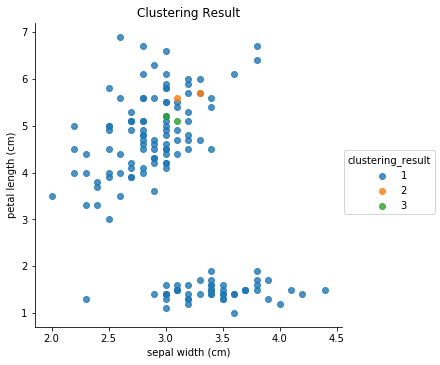

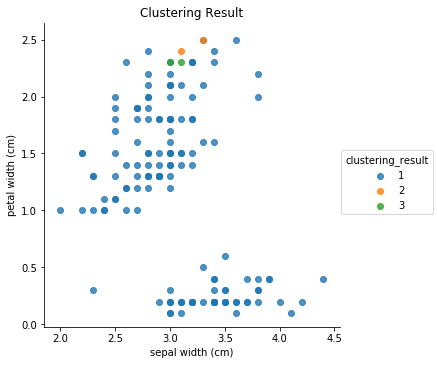

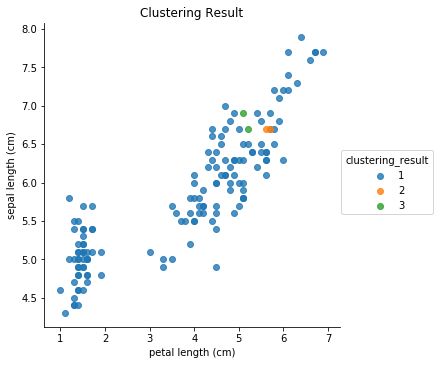

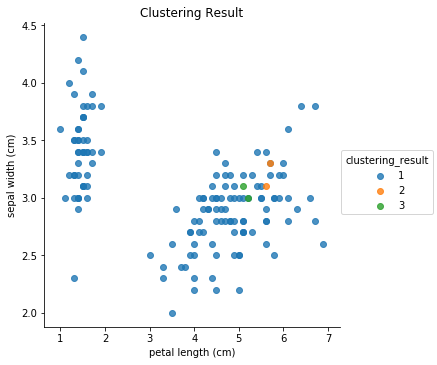

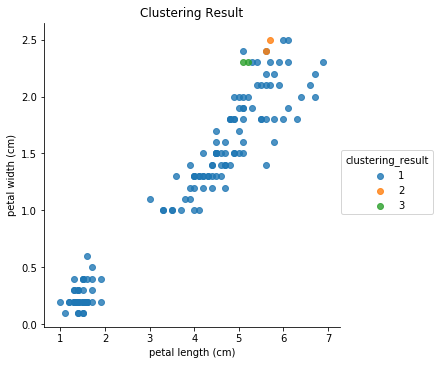

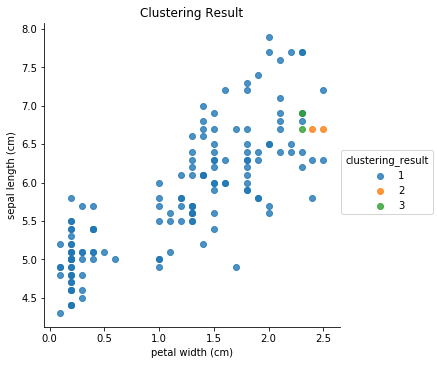

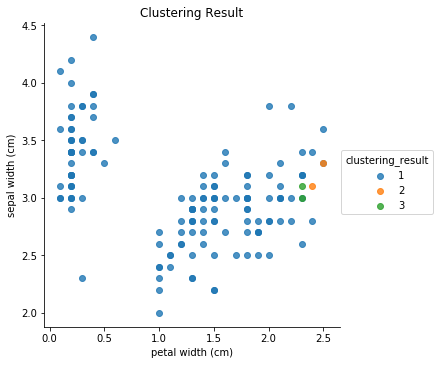

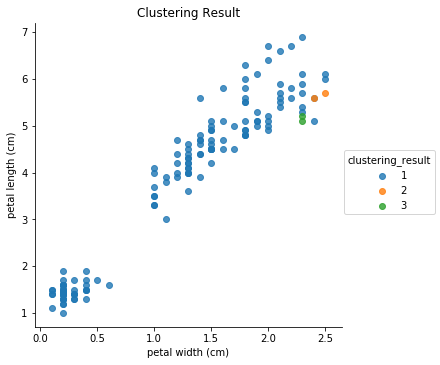

In [60]:
visualization_agglo_result(iris_X, 3, "average-group")

## Analisis 


## K-Means

Berdasarkan hasil evaluasi dengan pendekatan Fowlkes-Mallows, dapat diketahui bahwa hasil pengujian memiliki tingkat kemiripan yang tinggi dengan label yang diberikan sebelumnya karena mendekati 1. Berdasarkan hasil evaluasi dengan pendekatan Silhouette Coefficient, dapat diketahui bahwa pengujian ini relasi antara objek dalam klaster cukup dekat dan jarak antar klaster cukup jauh karena mendekati 1. 

Berdasarkan hasil visualisasi di atas terhadap berbagai kombinasi fitur, dapat diketahui bahwa algoritma K-Means yang telah diimplementasikan cukup baik untuk melakukan klasterisasi. Hal ini juga telah dibuktikan dengan evaluasi pendekatan Silhouette Coefficient sebesar 0.55 dan pendekatan Fowlkes-Mallows sebesar 0.81.

## Agglomerative Single

Berdasarkan hasil evaluasi dengan pendekatan Fowlkes-Mallows, dapat diketahui bahwa hasil pengujian memiliki tingkat kemiripan yang tinggi dengan label yang diberikan sebelumnya karena mendekati 1. Berdasarkan hasil evaluasi dengan pendekatan Silhouette Coefficient, dapat diketahui bahwa pengujian ini menghasilkan jarak antar klaster cukup dekat karena mendekati di antara -1 dan 1. Ini dikarenakan terdapat chaining effect sehingga penggunaan single linkage jarang menghasilkan solusi yang optimal.

Berdasarkan hasil visualisasi di atas terhadap berbagai kombinasi fitur, dapat diketahui bahwa algoritma Agglomerative dengan Single Linkage yang telah diimplementasikan tidak cukup baik untuk melakukan klasterisasi karena dapat dilihat terdapat 1 klaster yang berisi outlier dan terletak di dalam klaster lainnya yang lebih dominan. Hal ini juga telah dibuktikan dengan evaluasi pendekatan Silhouette Coefficient sebesar 0.13 dan pendekatan Fowlkes-Mallows sebesar 0.77.

## Agglomerative Complete

Berdasarkan hasil evaluasi dengan pendekatan Fowlkes-Mallows, dapat diketahui bahwa hasil pengujian memiliki tingkat kemiripan yang tinggi dengan label yang diberikan sebelumnya karena mendekati 1. Berdasarkan hasil evaluasi dengan pendekatan Silhouette Coefficient, dapat diketahui bahwa pengujian ini menghasilkan relasi antara objek dalam klaster cukup dekat dan jarak antar klaster cukup jauh karena mendekati 1. Dalam sudut pandang pragmatis, algoritma Agglomerative dengan complete linkage menghasilkan hierarki yang lebih baik dibandingkan single linkage karena dapat menghindari chaining effect.

Berdasarkan hasil visualisasi di atas terhadap berbagai kombinasi fitur, dapat diketahui bahwa algoritma Agglomerative dengan Complete Linkage yang telah diimplementasikan cukup baik untuk melakukan klasterisasi walaupun di beberapa kartesian kombinasi fitur terlihat bertabrakan antara klaster 2 dan 3. Hal ini juga telah dibuktikan dengan evaluasi pendekatan Silhouette Coefficient sebesar 0.51 dan pendekatan Fowlkes-Mallows sebesar 0.77.

## Agglomerative Average

Berdasarkan hasil evaluasi dengan pendekatan Fowlkes-Mallows, dapat diketahui bahwa hasil pengujian memiliki tingkat kemiripan yang tinggi dengan label yang diberikan sebelumnya karena mendekati 1. Berdasarkan hasil evaluasi dengan pendekatan Silhouette Coefficient, dapat diketahui bahwa pengujian ini menghasilkan relasi antara objek dalam klaster cukup dekat dan jarak antar klaster cukup jauh karena mendekati 1. Dalam average linkage, setiap subset klaster dapat memiliki kohesi yang berbeda sehingga tidak dapat dilakukan pra-komputasi terhadap semua kemungkinan klaster.

Berdasarkan hasil visualisasi di atas terhadap berbagai kombinasi fitur, dapat diketahui bahwa algoritma Agglomerative dengan Average Linkage yang telah diimplementasikan cukup baik untuk melakukan klasterisasi. Hal ini juga telah dibuktikan dengan evaluasi pendekatan Silhouette Coefficient sebesar 0.53 dan pendekatan Fowlkes-Mallows sebesar 0.74.

## Agglomerative Average-Group

Berdasarkan hasil evaluasi dengan pendekatan Fowlkes-Mallows, dapat diketahui bahwa hasil pengujian memiliki tingkat kemiripan yang cukup tinggi dengan label yang diberikan sebelumnya karena mendekati 1. Berdasarkan hasil evaluasi dengan pendekatan Silhouette Coefficient, dapat diketahui bahwa pengujian ini menghasilkan jarak antar klaster cukup dekat karena mendekati -1. Ini menunjukkan bahwa tingkat kohesi dalam suatu subset dalam klaster cukup beragam atau tidak merata.

Berdasarkan hasil visualisasi di atas terhadap berbagai kombinasi fitur, dapat diketahui bahwa algoritma Agglomerative dengan Average-Group Linkage yang telah diimplementasikan tidak cukup baik untuk melakukan klasterisasi karena dapat dilihat terdapat 1 klaster dominan yang mengelilingi klaster-klaster lainnya. Hal ini juga telah dibuktikan dengan evaluasi pendekatan Silhouette Coefficient sebesar -0.12 dan pendekatan Fowlkes-Mallows sebesar 0.56.